In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import Input,Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Embedding
from keras import regularizers
from keras.losses import mean_squared_error
import glob
import matplotlib.patches as patches
import json
import numpy as np
from matplotlib.path import Path
import dicom
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/sharonedayan/tensorflow/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


The second step of the algorithm is to train a stacked Auto-encoder in order to get the binary mask of the left ventricule inferred shape within the ROI (region of interest output of CNN). It is performed in two steps : pre-training then fine-tuning.

## Open DataSet

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


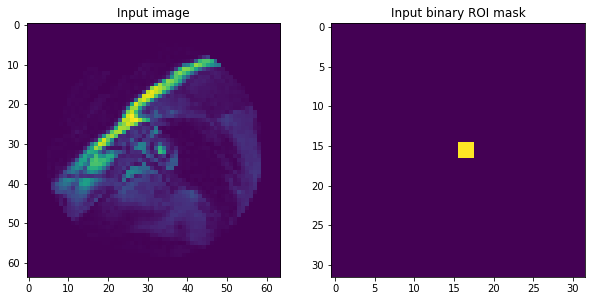

Size for each layer :
Layer, Input Size, Output Size
Conv2D_1 (None, 64, 64, 1) (None, 54, 54, 100)
Average_Pooling2D_1 (None, 54, 54, 100) (None, 9, 9, 100)
Reshape_1 (None, 9, 9, 100) (None, 1, 8100)
Dense_1 (None, 1, 8100) (None, 1, 1024)
Reshape_2 (None, 1, 1024) (None, 1, 32, 32)
Epoch 1/3
495/495 [==============================] - 13s - loss: 0.1830 - acc: 0.2064    
Epoch 2/3
495/495 [==============================] - 12s - loss: 0.1034 - acc: 0.1417    
Epoch 3/3
495/495 [==============================] - 12s - loss: 0.0765 - acc: 0.0691    


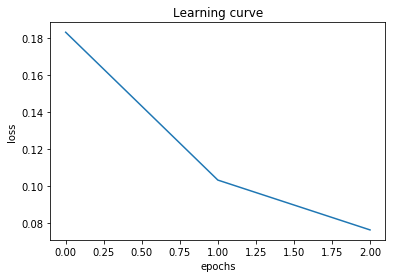

Stored 'y_pred' (ndarray)


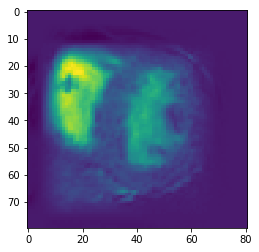

In [2]:
%run 'CNN.ipynb'

In [126]:
series = json.load(open('series_case.json')) 
images, images_fullsize, contours, contour_mask = [], [], [], []
for case, serie in series.items():
    image_path_base = './Data/challenge_training/%s/IM-%s' % (case, serie)
    contour_path_base = './Data/Sunnybrook Cardiac MR Database ContoursPart3/\
TrainingDataContours/%s/contours-manual/IRCCI-expert/' % case
    contours_list = glob.glob(contour_path_base + '*')
    contours_list_series = [k.split('/')[7].split('-')[2] for k in contours_list]
    for c in contours_list_series:
        # Get contours and images path
        idx_contour = contours_list_series.index(c)
        image_path = image_path_base + '-%s.dcm' % c
        contour_path = contours_list[idx_contour]

        # open image as numpy array and resize to (64, 64)
        image_part = dicom.read_file(image_path).pixel_array  

        # open contours as numpy array
        contour = []
        file = open(contour_path, 'r') 
        for line in file: 
            contour.append(tuple(map(float, line.split())))
        contour = np.array(contour)
        #mask des contours
        x, y = np.meshgrid(np.arange(256), np.arange(256)) # make a canvas with coordinates
        x, y = x.flatten(), y.flatten()
        points = np.vstack((x,y)).T 
        p = Path(contour) # make a polygon
        grid = p.contains_points(points)
        mask_contour = grid.reshape(256,256)
        mask_contour=mask_contour*1
        contour_mask.append(mask_contour)
        
        contours.append(get_roi(image_part, contour))

        images.append(cv2.resize(image_part, (64, 64)))
        images_fullsize.append(cv2.resize(image_part, (256, 256)))

X_fullsize = np.array(images_fullsize)
X = np.reshape(np.array(images), [len(images), 64, 64, 1])
Y = np.reshape(np.array(contours), [len(contours), 1, 32, 32])
#Z = np.reshape(np.array(contour_mask), [len(contour_mask), 64, 64, 1])
print('Dataset shape :', X.shape, Y.shape)

contour_mask = np.asarray(contour_mask)
l_contour=[] #resize (64,64)
for i in range(contour_mask.shape[0]):
    l_contour.append(cv2.resize(contour_mask[i], (64, 64), interpolation = cv2.INTERSECT_NONE))
l_contour = np.asarray(l_contour).reshape((-1, 64*64))

In [127]:
l_contour.shape

(495, 4096)

## Stacked auto-encoder

### 1rst part : another representation of the ROI with sparse auto-encoder

In [7]:
%store -r y_pred

In [8]:
y_pred.shape

(495, 1, 32, 32)

In [9]:
def reshape_image_100(y_pred, j):
    pred = y_pred[j].reshape((32,32))
    pos_pred = np.where(pred > 0.5)
    mask_roi = get_roi(pred, np.array(pos_pred).reshape(len(pos_pred[0]), 2))
    mask_roi = cv2.resize(mask_roi, (256, 256), interpolation = cv2.INTERSECT_FULL)
    pos_im = np.where(X_fullsize[j] * mask_roi > 0.5)
    contour2 = np.array(pos_im).reshape(len(pos_im[0]), 2)
    Xmin, Xmax = contour2[:, 0].min(), contour2[:, 0].max()
    Ymin, Ymax = contour2[:, 1].min(), contour2[:, 1].max()
    region_interest = (X_fullsize[j] * mask_roi)[Xmin:Xmax, Ymin:Ymax]
    region_interest_resize = cv2.resize(region_interest,(100, 100))
    return(region_interest_resize)

In [14]:
input_AE = [] #images (100,100)
for j in range(y_pred.shape[0]):
    input_AE.append(cv2.resize(reshape_image_100(y_pred, j),(64 , 64)))
input_AE = np.asarray(input_AE).reshape((-1, 64*64)) #unrolled : 64*64 = vector of 4096 elements

#### Model

In [73]:
from keras import losses
def customized_loss(y_true, y_pred):
    #customize your own loss components
    loss1 = losses.mean_absolute_error(y_true, y_pred)
    loss2 = losses.kullback_leibler_divergence(y_true, y_pred)
    #adjust the weight between loss components
    return 0.0001*0.5 * loss1 + 3 * loss2

In [88]:
model = Sequential()
model.add(Dense(100, kernel_regularizer=regularizers.l2(3*0.001), input_shape=[input_AE.shape[1]]))
model.add(Dense(4096, kernel_regularizer=regularizers.l2(3*0.001)))

In [89]:
for p in model.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_26 (None, 4096) (None, 100)
dense_27 (None, 100) (None, 4096)


#### Training

In [90]:
model.compile(loss= customized_loss,
              optimizer='adam')

In [91]:
h = model.fit(input_AE, input_AE, epochs=100, verbose=2)

Epoch 1/100
0s - loss: 40136.6898
Epoch 2/100
0s - loss: 11170.9820
Epoch 3/100
0s - loss: 6650.5151
Epoch 4/100
0s - loss: 6109.4755
Epoch 5/100
0s - loss: 5787.7832
Epoch 6/100
0s - loss: 5571.8387
Epoch 7/100
0s - loss: 5356.6759
Epoch 8/100
0s - loss: 5146.3240
Epoch 9/100
0s - loss: 4622.6990
Epoch 10/100
0s - loss: 4340.8760
Epoch 11/100
0s - loss: 4223.1717
Epoch 12/100
0s - loss: 4097.2139
Epoch 13/100
0s - loss: 4044.0434
Epoch 14/100
0s - loss: 3901.6326
Epoch 15/100
0s - loss: 3793.6252
Epoch 16/100
0s - loss: 3706.7368
Epoch 17/100
0s - loss: 3679.7553
Epoch 18/100
0s - loss: 3674.3524
Epoch 19/100
0s - loss: 3668.5345
Epoch 20/100
0s - loss: 3671.3675
Epoch 21/100
0s - loss: 3619.8758
Epoch 22/100
0s - loss: 3599.6724
Epoch 23/100
0s - loss: 3557.3257
Epoch 24/100
0s - loss: 3509.4633
Epoch 25/100
0s - loss: 3502.4882
Epoch 26/100
0s - loss: 3437.9281
Epoch 27/100
0s - loss: 3365.1384
Epoch 28/100
0s - loss: 3338.6194
Epoch 29/100
0s - loss: 3309.0739
Epoch 30/100
0s - los

Text(0.5,0,'epochs')

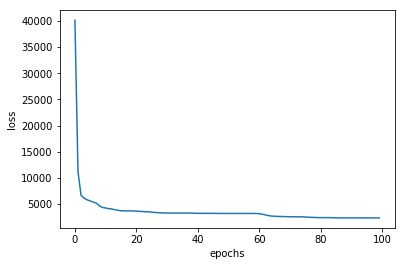

In [92]:
metric = 'loss'
plt.plot(range(len(h.history[metric])), h.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

#### Prediction

In [93]:
input_AE_pred = model.predict(input_AE)

In [94]:
pred = input_AE_pred[0].reshape(64, 64)

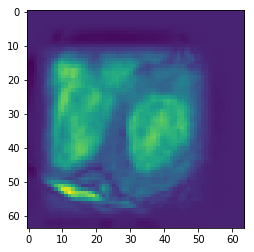

In [95]:
plt.imshow(input_AE[0].reshape(64,64))

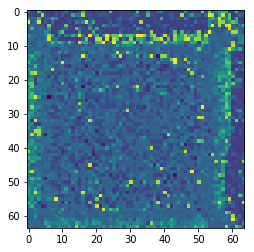

In [96]:
plt.imshow(pred)

#### 2nd part : From new representation of ROI to inferred shape using annotated contours

In [128]:
input_y = l_contour
input_x = input_AE_pred

In [130]:
model = Sequential()
model.add(Dense(100, kernel_regularizer=regularizers.l2(3*0.001), input_shape=[input_AE.shape[1]]))
model.add(Dense(4096, kernel_regularizer=regularizers.l2(3*0.001)))
#model.add(Dense(4096,  input_shape=[l2.shape[1]*l2.shape[2]]))
#model.add(Dense(100, input_shape=[l2.shape[1]]))

In [131]:
for p in model.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_30 (None, 4096) (None, 100)
dense_31 (None, 100) (None, 4096)


In [132]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [133]:
h2 = model.fit(input_x, input_y, epochs=10, verbose=2)

Epoch 1/10
1s - loss: 39027.0369 - acc: 0.0000e+00
Epoch 2/10
0s - loss: 1830.0088 - acc: 0.0000e+00
Epoch 3/10
0s - loss: 469.0600 - acc: 0.0000e+00
Epoch 4/10
0s - loss: 154.2052 - acc: 0.0000e+00
Epoch 5/10
0s - loss: 92.8750 - acc: 0.0000e+00
Epoch 6/10
0s - loss: 71.4033 - acc: 0.0000e+00
Epoch 7/10
0s - loss: 56.8216 - acc: 0.0000e+00
Epoch 8/10
0s - loss: 299.6128 - acc: 0.0000e+00
Epoch 9/10
0s - loss: 139.2172 - acc: 0.0000e+00
Epoch 10/10
0s - loss: 84.2801 - acc: 0.0000e+00


Text(0.5,0,'epochs')

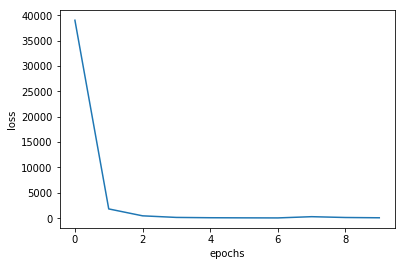

In [134]:
metric = 'loss'
plt.plot(range(len(h2.history[metric])), h2.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

In [135]:
l3_pred = model.predict(input_x)

In [136]:
pred3 = l3_pred[0].reshape(64, 64)

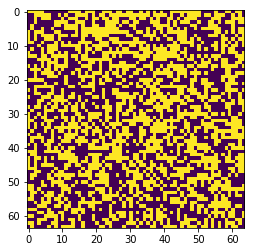

In [137]:
j = 17
# select one predicted ROI
pred3 = l3_pred[j].reshape((64,64))
p = cv2.threshold(pred3, 0, 1, cv2.THRESH_BINARY)
plt.imshow(p[1])

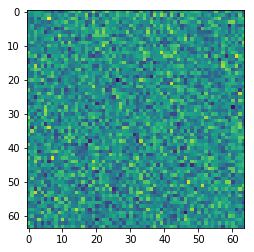

In [138]:
plt.imshow(pred3)